## Capstone project function 1 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern, WhiteKernel
import matplotlib.pyplot as plt
import sklearn
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from scipy.interpolate import griddata
import ast
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.spatial.distance import cdist

#### Function summary

A 2D array with 10 input points. Function is to detect likely contamination sources in a two-dimensional area, such as a radiation field, where only proximity yields a non-zero reading. The system uses Bayesian optimisation to tune detection parameters and reliably identify both strong and weak sources.

### Step 1: Load in data and plot

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048]


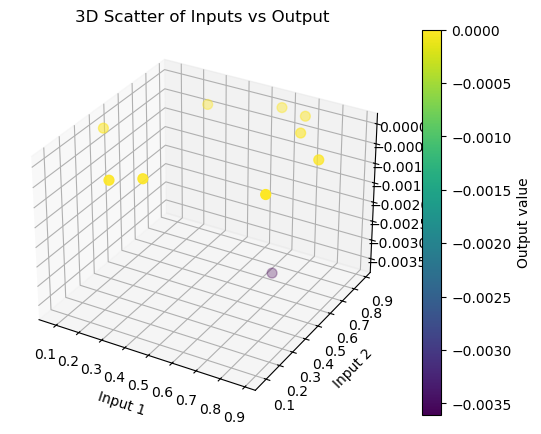

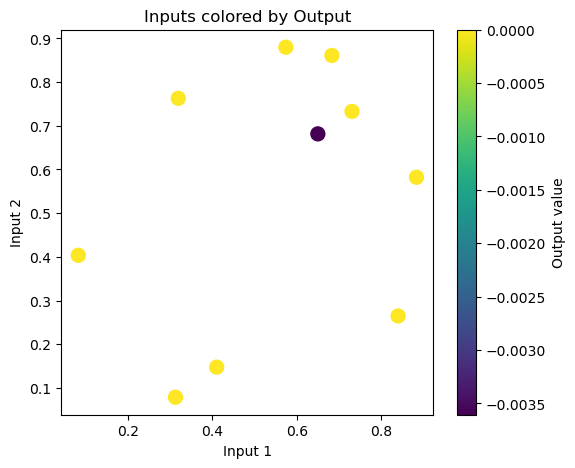

In [7]:
inputdata = np.load('initial_inputs.npy')
outputdata = np.load('initial_outputs.npy')

# Now plot the data
# Flatten output to 1D
y = outputdata.flatten()
x1 = inputdata[:,0]
x2 = inputdata[:,1]
X = inputdata
print(inputdata)
print(outputdata)

# 3D scatter plot
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x1, x2, y, c=y, cmap='viridis', s=50)
ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Output')
plt.title('3D Scatter of Inputs vs Output')
plt.colorbar(sc, label='Output value')
plt.show()

#2D scatter plot 
plt.figure(figsize=(6,5))
plt.scatter(x1, x2, c=y, cmap='viridis', s=100)
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Inputs colored by Output')
plt.colorbar(label='Output value')
plt.show()

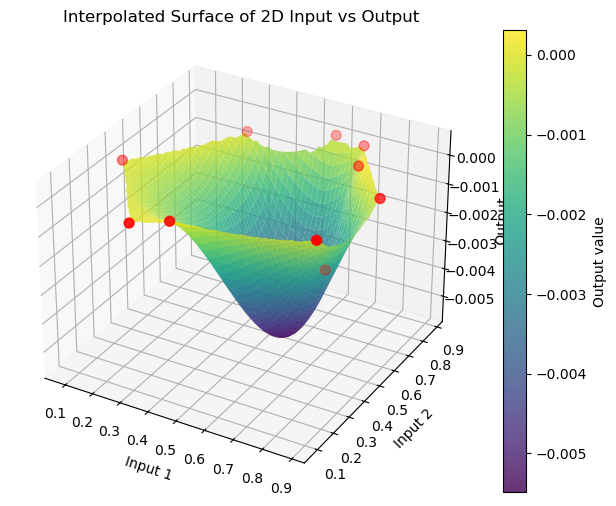

In [11]:
# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 100),
    np.linspace(x2.min(), x2.max(), 100)
)

# Interpolate output values on the grid
grid_z = griddata((x1, x2), y, (grid_x, grid_y), method='cubic')

# Plot surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)

# Plot original points on top
ax.scatter(x1, x2, y, color='red', s=50, label='Original points')

ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Output')
plt.title('Interpolated Surface of 2D Input vs Output')
fig.colorbar(surf, label='Output value')
plt.show()

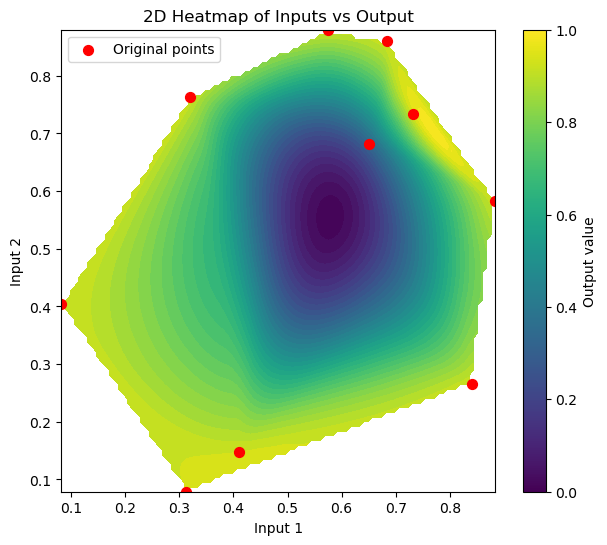

In [12]:
# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 100),
    np.linspace(x2.min(), x2.max(), 100)
)

# Interpolate output values on the grid
grid_z = griddata((x1, x2), y, (grid_x, grid_y), method='cubic')

# Plot heatmap
plt.figure(figsize=(7,6))
plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis')
plt.scatter(x1, x2, color='red', s=50, label='Original points')  # plot original points
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('2D Heatmap of Inputs vs Output')
plt.colorbar(label='Output value')
plt.legend()
plt.show()


### Step 2: Fit surrogate model - In this instance a Gaussian Processor

In [50]:
# First log transform
epsilon = 1e-10  # shift to avoid log(0) or negative values
y_shifted = y + 0.01  # shift all values to be positive (adjust 0.01 as needed)
y_log = np.log(y_shifted)

#Then fit surrogate model
kernel = Matern(length_scale=1.0, nu=2.5) 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X, y_log)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10, random_state=42)

### Step 3: Create candidate points

In [51]:
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])

### Step 4: Compute GP points

In [52]:
mu, sigma = gp.predict(X_candidates, return_std=True)
print(mu)
print(sigma)

[-3.84292431 -3.88444655 -3.92488985 ... -3.33226559 -3.28938761
 -3.24650368]
[0.48542389 0.47133245 0.45703686 ... 0.49501059 0.50766245 0.52019906]


### Step 5: Apply acquisition function - in this case UCB

In [54]:
kappa = 3  # Exploration-exploitation tradeoff, may want to start with a higher exploration value than usual 2
UCB = mu + kappa * sigma

### Step 6: Select the next point

In [55]:
next_idx = np.argmax(UCB)
x_next = X_candidates[next_idx]
print("Next coordinate to explore:", x_next)

Next coordinate to explore: [0. 1.]


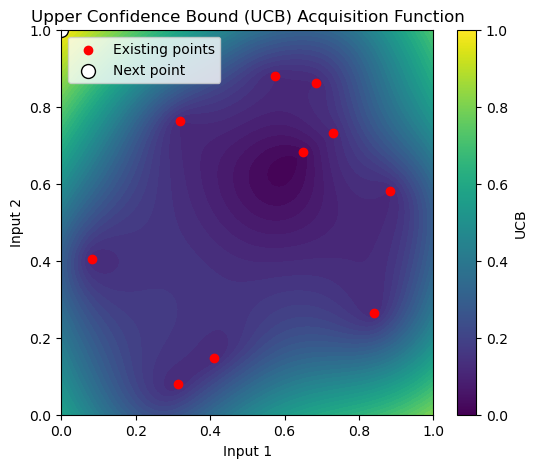

In [56]:
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB.reshape(X1.shape), levels=50, cmap='viridis')
plt.scatter(X[:,0], X[:,1], c='red', label='Existing points')
plt.scatter(x_next[0], x_next[1], c='white', s=100, edgecolors='black', label='Next point')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Upper Confidence Bound (UCB) Acquisition Function')
plt.colorbar(label='UCB')
plt.legend()
plt.show()

## ******* Week 2 - update of function ********

### Step 2: Load in the result from week one tuning option and concatenate to original array

In [3]:
#Read in text file of inputs
with open('../Archived/Week1/inputs.txt', 'r') as f:
    inputs_week2 = f.read()

with open('../Archived/Week1/outputs.txt', 'r') as f:
    outputs_week2 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week2 = eval(inputs_week2, {"__builtins__": {}}, safe_globals)
outputs_week2 = eval(outputs_week2, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week2 = np.array(inputs_week2, dtype=object)
outputs_week2 = np.array(outputs_week2, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week2 = inputs_week2[0]
F1_outputs_week2 = outputs_week2[0]


# Step 5: merge with previous data
F1_inputs_week2 = F1_inputs_week2.reshape(1, -1)
inputdata_week2 = np.concatenate((inputdata,F1_inputs_week2), axis=0)

outputdata_week2 = np.concatenate((outputdata,np.array([F1_outputs_week2])))

print(inputdata_week2)
print(outputdata_week2)

# Now save this data as the .npy arrays to work with moving forward
np.save('inputs_week2.npy',inputdata_week2)
np.save('outputs_week2.npy', outputdata_week2)

FileNotFoundError: [Errno 2] No such file or directory: '../Archived/Week1/inputs.txt'

### Step 2: Review new information 

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000]


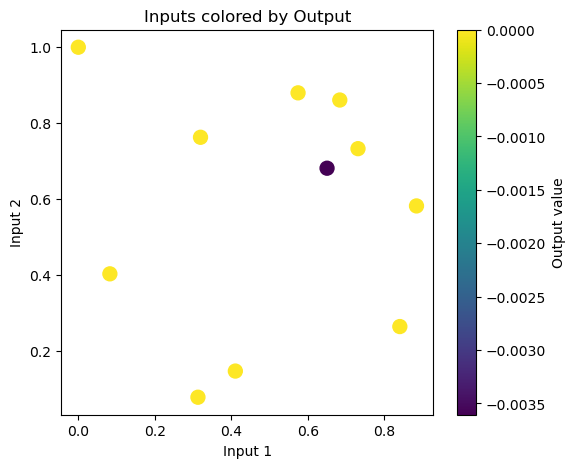

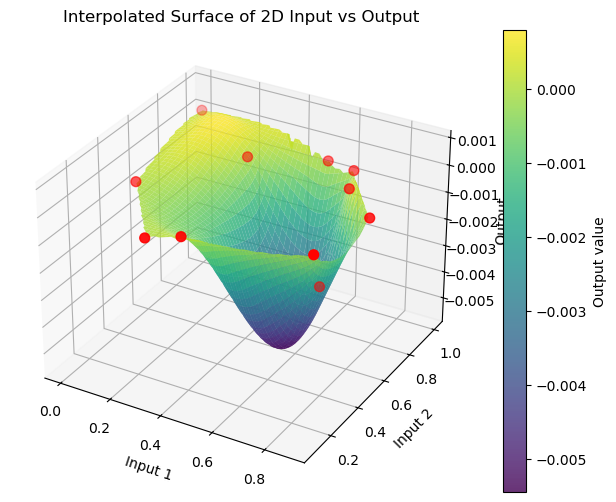

In [54]:
# Now plot the data
# Flatten output to 1D
y = outputdata_week2.flatten()
x1 = inputdata_week2[:,0]
x2 = inputdata_week2[:,1]
X = inputdata_week2
print(inputdata_week2)
print(outputdata_week2)

#2D scatter plot 
plt.figure(figsize=(6,5))
plt.scatter(x1, x2, c=y, cmap='viridis', s=100)
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Inputs colored by Output')
plt.colorbar(label='Output value')
plt.show()


# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 100),
    np.linspace(x2.min(), x2.max(), 100)
)

# Interpolate output values on the grid
grid_z = griddata((x1, x2), y, (grid_x, grid_y), method='cubic')

# Plot surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)

# Plot original points on top
ax.scatter(x1, x2, y, color='red', s=50, label='Original points')

ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Output')
plt.title('Interpolated Surface of 2D Input vs Output')
fig.colorbar(surf, label='Output value')
plt.show()


### Step 3: Now fit a surrogate model 

In [55]:
# First log transform
epsilon = 1e-10  # shift to avoid log(0) or negative values
y_shifted = y + 0.01  # shift all values to be positive (adjust 0.01 as needed)
y_log = np.log(y_shifted)

#Then fit surrogate model
kernel = Matern(length_scale=1.0, nu=2.5) 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X, y_log)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10, random_state=42)

### Step 4: Now consider acquisition function and whether we want to change anything now we have a new data point

In [60]:
# Create candidate points to search within
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])

## Compute GP points
mu, sigma = gp.predict(X_candidates, return_std=True)
print(mu)
print(sigma)

[-3.80848535 -3.84994869 -3.89047766 ... -3.2752272  -3.22917721
 -3.18322912]
[0.49758639 0.48335913 0.46890976 ... 0.50742545 0.52017564 0.53279638]


In [61]:
### Likely still want to use UCB and look at exploration in this example
kappa = 3  # Exploration-exploitation tradeoff, may want to start with a higher exploration value than usual 2
UCB = mu + kappa * sigma

### Step 5: Select the next point based on this exploration

In [62]:
next_idx = np.argmax(UCB)
x_next = X_candidates[next_idx]
print("Next coordinate to explore:", x_next)

Next coordinate to explore: [1. 0.]


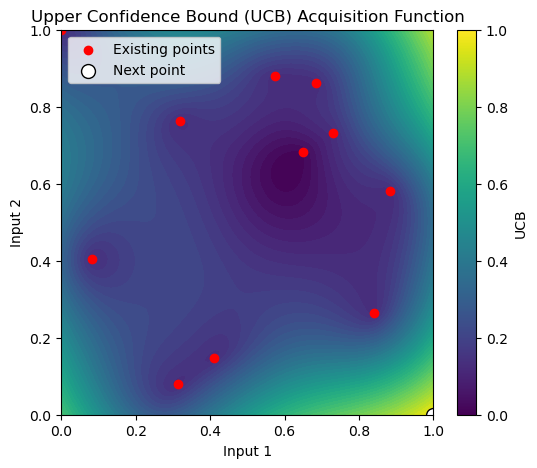

In [66]:
# Plot 
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB.reshape(X1.shape), levels=50, cmap='viridis')
plt.scatter(X[:,0], X[:,1], c='red', label='Existing points')
plt.scatter(x_next[0], x_next[1], c='white', s=100, edgecolors='black', label='Next point')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Upper Confidence Bound (UCB) Acquisition Function')
plt.colorbar(label='UCB')
plt.legend()
plt.show()


[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000]


## ***** Week 3 - update of function *******

## Step 1: Load in optimisation results from week 2

In [4]:
#Load in original input and output data 
inputdata = np.load('inputs_week2.npy')
outputdata = np.load('outputs_week2.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week2/inputs.txt', 'r') as f:
    inputs_week3 = f.read()

with open('../Inputs_Outputs/Week2/outputs.txt', 'r') as f:
    outputs_week3 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week3 = eval(inputs_week3, {"__builtins__": {}}, safe_globals)
outputs_week3 = eval(outputs_week3, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week3 = np.array(inputs_week3, dtype=object)
outputs_week3 = np.array(outputs_week3, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week3 = inputs_week3[0]
F1_outputs_week3 = outputs_week3[0]


# Step 5: merge with previous data
F1_inputs_week3 = F1_inputs_week3.reshape(1, -1)
inputdata_week3 = np.concatenate((inputdata,F1_inputs_week3), axis=0)

outputdata_week3 = np.concatenate((outputdata,np.array([F1_outputs_week3])))

print(inputdata_week3)
print(outputdata_week3)

# Save the results of these
np.save('inputs_week3.npy',inputdata_week3)
np.save('outputs_week3.npy', outputdata_week3)

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000]


### Step 2: Now plot with the new output information

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000]


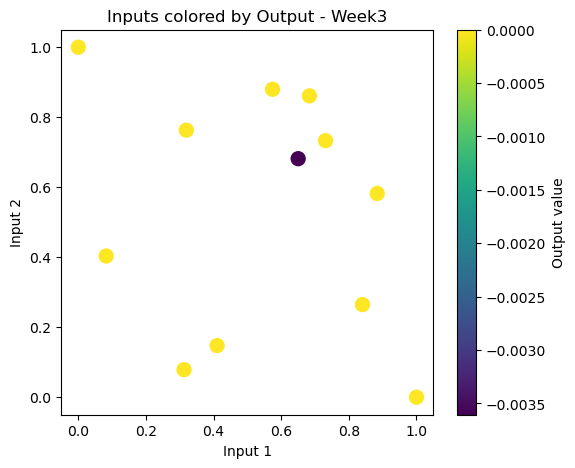

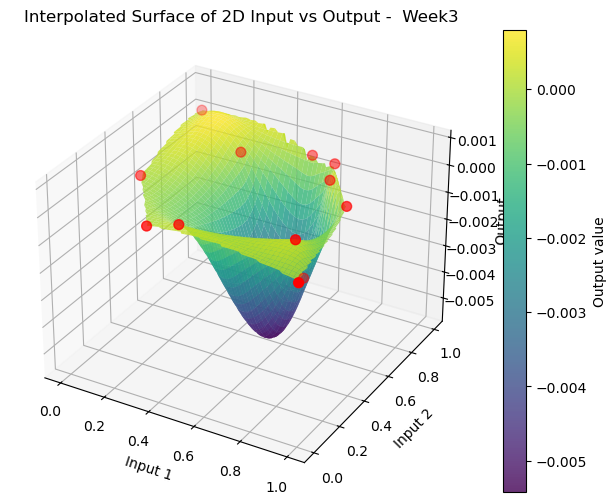

In [15]:
# Now plot the data
# Flatten output to 1D
y = outputdata_week3.flatten()
x1 = inputdata_week3[:,0]
x2 = inputdata_week3[:,1]
X = inputdata_week3
print(inputdata_week3)
print(outputdata_week3)

#2D scatter plot 
plt.figure(figsize=(6,5))
plt.scatter(x1, x2, c=y, cmap='viridis', s=100)
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Inputs colored by Output - Week3')
plt.colorbar(label='Output value')
plt.show()


# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 100),
    np.linspace(x2.min(), x2.max(), 100)
)

# Interpolate output values on the grid
grid_z = griddata((x1, x2), y, (grid_x, grid_y), method='cubic')

# Plot surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)

# Plot original points on top
ax.scatter(x1, x2, y, color='red', s=50, label='Original points')

ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Output')
plt.title('Interpolated Surface of 2D Input vs Output -  Week3')
fig.colorbar(surf, label='Output value')
plt.show()

### Step 3: Now refit surrogate model - Guassian process

In [16]:
# First log transform
epsilon = 1e-10  # shift to avoid log(0) or negative values
y_shifted = y + 0.01  # shift all values to be positive (adjust 0.01 as needed)
y_log = np.log(y_shifted)

#Then fit surrogate model
kernel = Matern(length_scale=1.0, nu=2.5) 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X, y_log)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10, random_state=42)

### Now consider acquisition function and whether we want to continue to exploit or explore

In [17]:
# Create candidate points to search within
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])

## Compute GP points
mu, sigma = gp.predict(X_candidates, return_std=True)
print(mu)
print(sigma)

[-3.73094582 -3.77288075 -3.81402091 ... -3.31142822 -3.26853837
 -3.22576273]
[0.49910315 0.48484045 0.47035384 ... 0.50937241 0.52211199 0.53471843]


In [19]:
### Likely still want to use UCB and look at exploration in this example
kappa = 2.5  # Exploration-exploitation tradeoff, may want to start with a higher exploration value than usual 2
UCB = mu + kappa * sigma

### Step 4: Now consider next best point

In [20]:
next_idx = np.argmax(UCB)
x_next = X_candidates[next_idx]
print("Next coordinate to explore:", x_next)

Next coordinate to explore: [1. 1.]


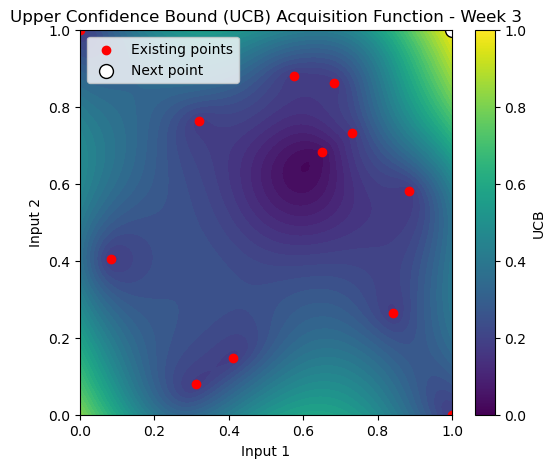

In [21]:
# Plot 
plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB.reshape(X1.shape), levels=50, cmap='viridis')
plt.scatter(X[:,0], X[:,1], c='red', label='Existing points')
plt.scatter(x_next[0], x_next[1], c='white', s=100, edgecolors='black', label='Next point')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Upper Confidence Bound (UCB) Acquisition Function - Week 3')
plt.colorbar(label='UCB')
plt.legend()
plt.show()

# ******* Week 4 update **********

## Step 1: Load in optimisation results from week 2

In [7]:
#Load in original input and output data 
inputdata = np.load('inputs_week3.npy')
outputdata = np.load('outputs_week3.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week3/inputs.txt', 'r') as f:
    inputs_week4 = f.read()

with open('../Inputs_Outputs/Week3/outputs.txt', 'r') as f:
    outputs_week4 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week4 = eval(inputs_week4, {"__builtins__": {}}, safe_globals)
outputs_week4 = eval(outputs_week4, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week4 = np.array(inputs_week4, dtype=object)
outputs_week4 = np.array(outputs_week4, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week4 = inputs_week4[0]
F1_outputs_week4 = outputs_week4[0]


# Step 5: merge with previous data
F1_inputs_week4 = F1_inputs_week4.reshape(1, -1)
inputdata_week4 = np.concatenate((inputdata,F1_inputs_week4), axis=0)

outputdata_week4 = np.concatenate((outputdata,np.array([F1_outputs_week3])))

print(inputdata_week4)
print(outputdata_week4)

# Save the results of these
np.save('inputs_week4.npy',inputdata_week4)
np.save('outputs_week4.npy', outputdata_week4)

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]
 [1.         1.        ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000
  0.00000000e+000]


### Step 2: Now plot with new information

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]
 [1.         1.        ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000
  0.00000000e+000]


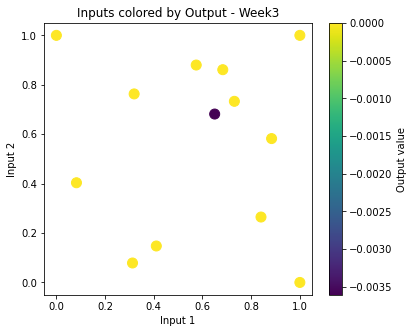

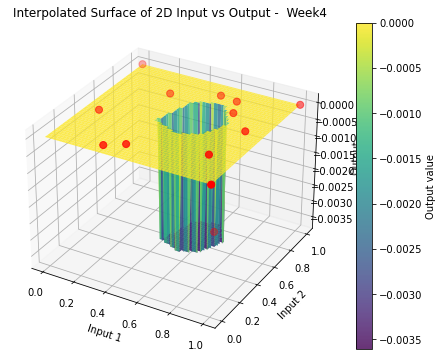

In [10]:
# Now plot the data
# Flatten output to 1D
y = outputdata_week4.flatten()
x1 = inputdata_week4[:,0]
x2 = inputdata_week4[:,1]
X = inputdata_week4
print(inputdata_week4)
print(outputdata_week4)

#2D scatter plot 
plt.figure(figsize=(6,5))
plt.scatter(x1, x2, c=y, cmap='viridis', s=100)
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Inputs colored by Output - Week3')
plt.colorbar(label='Output value')
plt.show()


# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 100),
    np.linspace(x2.min(), x2.max(), 100)
)

# Interpolate output values on the grid
grid_z = griddata((x1, x2), y, (grid_x, grid_y), method='nearest')

# Plot surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)

# Plot original points on top
ax.scatter(x1, x2, y, color='red', s=50, label='Original points')

ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Output')
plt.title('Interpolated Surface of 2D Input vs Output -  Week4')
fig.colorbar(surf, label='Output value')
plt.show()

### Step 3: Now refit surrogate model - Guassian process

In [30]:
# What we can see from the above plot is that we are finding lots of zeros (e.g., no radiation) but limited non-zeros.
# We may want to switch out focus now to finding non-zeros.
# We have fallen into BO trap of exploiting the zeros where in fact we want to find non-zero. So we must change
# An SVM approach with BO may be a good way of identifying the more rare non-zero spaces in this data


EPS = 1e-8
active = (np.abs(y) > EPS).astype(int)

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svm = make_pipeline(
    StandardScaler(),
    SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        probability=True,   # 
        class_weight="balanced",
        random_state=42
    )
)

svm.fit(X, active)

# Train GP on non-zero points
X_active = X[active == 1]
y_active = y[active == 1]

EPS = 1e-12

if len(y_active) >= 3:
    X_gp = X_active
    y_gp = np.log10(np.abs(y_active) + EPS)
else:
    X_gp = X
    y_gp = np.log10(np.abs(y) + EPS)

gp.fit(X_gp, y_gp)

/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=Matern(length_scale=0.3, nu=2.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=42)

### Get acquiisition

In [29]:
# Candidate points
p_active = svm.predict_proba(X_candidates)[:, 1]

mu, sigma = gp.predict(X_candidates, return_std=True)

kappa = 2.0
lcb = mu - kappa * sigma

acq = p_active * lcb
print(acq)

[-1.93768302 -1.93765682 -1.93762764 ... -1.95317627 -1.95331807
 -1.43301735]


#### Mask already evaluated points

In [32]:
from scipy.spatial.distance import cdist

min_dist = np.min(cdist(X_candidates, X), axis=1)
acq[min_dist < 5e-3] = -np.inf

x_next = X_candidates[np.argmax(acq)]
print(np.round(x_next,6))

[0.57047  0.536913]


#### Summary of what was performed

**Problem**
I have a sparse, mostly-zero output function 

I want Bayesian optimisation to focus on non-zero outputs, not waste time in zero regions.

Standard BO (single GP with UCB/LCB) was failing:

-> Repeated edges/corners

-> Ignoring rare non-zero points

-> Collapsing in flat zero regions

** Approach **

1. Create binary output so that 1's= non-zero and 0's = close to zero or zero outputs
2. Train an SVM classifier to identify zero from non-zero regions based on input values
3. Train GP on non-zero outputs
4. Compute acquisition function on this (using LCB to encourage exploration) . This effectively combines probability of activity × expected magnitude.
5. Exclude already evaluated points
6. Select next BO point.

** Summary **
Therefore: This two-stage approach turns a sparse, mostly-zero function into a tractable BO problem by explicitly modeling where outputs exist (SVM) and how big they are (GP), then combines them in a principled acquisition function. This is acheived through:

Separates zeros from non-zeros → avoids wasting evaluations.

Learns the magnitude landscape only where it matters (non-zero points).

Prevents repeated sampling of known points → no more corners/edges.

Focuses BO acquisition on promising regions = P(non-zero) × LCB.

Stable early behaviour with very few non-zero points.

Optional: SVM can be replaced with GPClassifier, but SVM is simpler and more robust in low dimensions.

# **** Week 5 update ****

## Step 1: Load in new data from previous week

In [3]:
#Load in original input and output data 
inputdata = np.load('inputs_week4.npy')
outputdata = np.load('outputs_week4.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week4/inputs.txt', 'r') as f:
    inputs_week5 = f.read()

with open('../Inputs_Outputs/Week4/outputs.txt', 'r') as f:
    outputs_week5 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week5 = eval(inputs_week5, {"__builtins__": {}}, safe_globals)
outputs_week5 = eval(outputs_week5, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week5 = np.array(inputs_week5, dtype=object)
outputs_week5 = np.array(outputs_week5, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week5 = inputs_week5[0]
F1_outputs_week5 = outputs_week5[0]


# Step 5: merge with previous data
F1_inputs_week5 = F1_inputs_week5.reshape(1, -1)
inputdata_week5 = np.concatenate((inputdata,F1_inputs_week5), axis=0)

outputdata_week5 = np.concatenate((outputdata,np.array([F1_outputs_week5])))

print(inputdata_week5)
print(outputdata_week5)

# Save the results of these
np.save('inputs_week5.npy',inputdata_week5)
np.save('outputs_week5.npy', outputdata_week5)

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]
 [1.         1.        ]
 [0.57047    0.536913  ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000
  0.00000000e+000  7.87269519e-009]


## Step 2: Plot the new outputs 

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]
 [1.         1.        ]
 [0.57047    0.536913  ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000
  0.00000000e+000  7.87269519e-009]


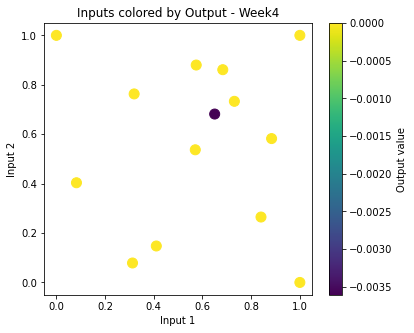

/var/folders/6g/73j8cd_50jx2t57s_f2s9jyw0000gn/T/ipykernel_48875/947299378.py:32: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)


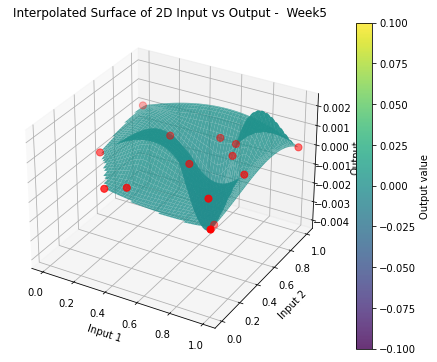

In [6]:
# Now plot the data
# Flatten output to 1D
y = outputdata_week5.flatten()
x1 = inputdata_week5[:,0]
x2 = inputdata_week5[:,1]
X = inputdata_week5
print(inputdata_week5)
print(outputdata_week5)

#2D scatter plot 
plt.figure(figsize=(6,5))
plt.scatter(x1, x2, c=y, cmap='viridis', s=100)
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Inputs colored by Output - Week4')
plt.colorbar(label='Output value')
plt.show()


# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 100),
    np.linspace(x2.min(), x2.max(), 100)
)

# Interpolate output values on the grid
grid_z = griddata((x1, x2), y, (grid_x, grid_y), method='cubic')

# Plot surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)

# Plot original points on top
ax.scatter(x1, x2, y, color='red', s=50, label='Original points')

ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Output')
plt.title('Interpolated Surface of 2D Input vs Output -  Week5')
fig.colorbar(surf, label='Output value')
plt.show()

## Step 3: Consider searching further with GP model

In [12]:
EPS = 1e-8
active = (np.abs(y) > EPS).astype(int)

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svm = make_pipeline(
    StandardScaler(),
    SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        probability=True,   # 
        class_weight="balanced",
        random_state=42
    )
)

svm.fit(X, active)

# Train GP on non-zero points
X_active = X[active == 1]
y_active = y[active == 1]

EPS = 1e-12

if len(y_active) >= 3:
    X_gp = X_active
    y_gp = np.log10(np.abs(y_active) + EPS)
else:
    X_gp = X
    y_gp = np.log10(np.abs(y) + EPS)

kernel = Matern(length_scale=1.0, nu=2.5) 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_gp, y_gp)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10, random_state=42)

### Get acquisition

In [14]:
# Candidate points

# Create candidate points to search within
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])


p_active = svm.predict_proba(X_candidates)[:, 1]

mu, sigma = gp.predict(X_candidates, return_std=True)

kappa = 2.0
lcb = mu - kappa * sigma

acq = p_active * lcb
print(acq)

[-0.50979069 -0.52658697 -0.54418022 ... -1.46121113 -1.43783349
 -1.40856063]


### Mask already evaluated points

In [15]:
from scipy.spatial.distance import cdist

min_dist = np.min(cdist(X_candidates, X), axis=1)
acq[min_dist < 5e-3] = -np.inf

x_next = X_candidates[np.argmax(acq)]
print(np.round(x_next,6))

[0.616162 0.666667]


# ***** Week 6 update *****

## Step 1: Load in data

In [3]:
#Load in original input and output data 
inputdata = np.load('inputs_week5.npy')
outputdata = np.load('outputs_week5.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week5/inputs.txt', 'r') as f:
    inputs_week6 = f.read()

with open('../Inputs_Outputs/Week5/outputs.txt', 'r') as f:
    outputs_week6 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week6 = eval(inputs_week6, {"__builtins__": {}}, safe_globals)
outputs_week6 = eval(outputs_week6, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week6 = np.array(inputs_week6, dtype=object)
outputs_week6 = np.array(outputs_week6, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week6 = inputs_week6[0]
F1_outputs_week6 = outputs_week6[0]


# Step 5: merge with previous data
F1_inputs_week6 = F1_inputs_week6.reshape(1, -1)
inputdata_week6 = np.concatenate((inputdata,F1_inputs_week6), axis=0)

outputdata_week6 = np.concatenate((outputdata,np.array([F1_outputs_week6])))

print(inputdata_week6)
print(outputdata_week6)

# Save the results of these
np.save('inputs_week6.npy',inputdata_week6)
np.save('outputs_week6.npy', outputdata_week6)

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]
 [1.         1.        ]
 [0.57047    0.536913  ]
 [0.616162   0.666667  ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000
  0.00000000e+000  7.87269519e-009  6.14805652e-003]


## Step 2: Plot output

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]
 [1.         1.        ]
 [0.57047    0.536913  ]
 [0.616162   0.666667  ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000
  0.00000000e+000  7.87269519e-009  6.14805652e-003]


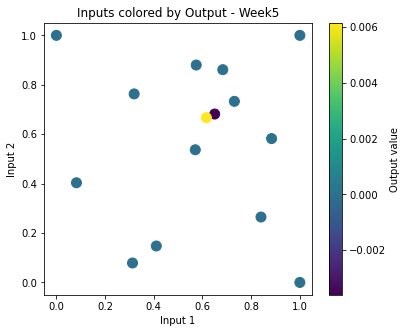

/var/folders/6g/73j8cd_50jx2t57s_f2s9jyw0000gn/T/ipykernel_42535/598638154.py:32: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)


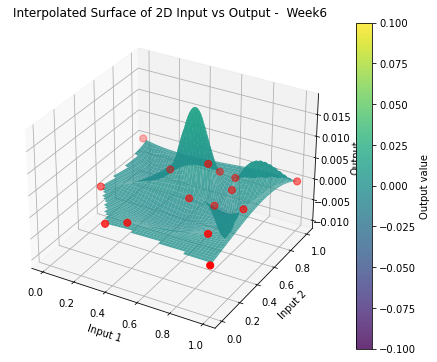

In [4]:
# Now plot the data
# Flatten output to 1D
y = outputdata_week6.flatten()
x1 = inputdata_week6[:,0]
x2 = inputdata_week6[:,1]
X = inputdata_week6
print(inputdata_week6)
print(outputdata_week6)

#2D scatter plot 
plt.figure(figsize=(6,5))
plt.scatter(x1, x2, c=y, cmap='viridis', s=100)
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Inputs colored by Output - Week5')
plt.colorbar(label='Output value')
plt.show()


# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 100),
    np.linspace(x2.min(), x2.max(), 100)
)

# Interpolate output values on the grid
grid_z = griddata((x1, x2), y, (grid_x, grid_y), method='cubic')

# Plot surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)

# Plot original points on top
ax.scatter(x1, x2, y, color='red', s=50, label='Original points')

ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Output')
plt.title('Interpolated Surface of 2D Input vs Output -  Week6')
fig.colorbar(surf, label='Output value')
plt.show()

## Step 3: Use SVM to continue search: making it more discriminative using sharper values, and making kernel less smooth for proximity related requirements

In [20]:
EPS = 1e-8
active = (np.abs(y) > EPS).astype(int)

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Have updated SVM : was too permissive, now i have improved discrimination by making SVM sharper. Reducing false positives in empty regions

svm = make_pipeline(
    StandardScaler(),
    SVC(
    kernel="rbf",
    C=50.0,          # stronger margin
    gamma=5.0,       # tighter locality
    probability=True,
    class_weight={0:1, 1:3},  # bias toward active regions
    random_state=42
)
)

svm.fit(X, active)

# Train GP on non-zero points
X_active = X[active == 1]
y_active = y[active == 1]

EPS = 1e-12

if len(y_active) >= 3:
    X_gp = X_active
    y_gp = np.log10(np.abs(y_active) + EPS)
else:
    X_gp = X
    y_gp = np.log10(np.abs(y) + EPS)

kernel = Matern(length_scale=0.15, nu=1.5) ## Kernal was too smooth for proximity only, so have updated from nu=2.5 to 1.5
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_gp, y_gp)

GaussianProcessRegressor(kernel=Matern(length_scale=0.15, nu=1.5),
                         n_restarts_optimizer=10, random_state=42)

## Step 4: Acquisition function: updated to UCB and biased my acquistion points to eliminate corners

In [21]:
# Candidate points

# Create candidate points to search within
x1 = np.linspace(0.5, 1, 100)
x2 = np.linspace(0.5, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])


p_active = svm.predict_proba(X_candidates)[:, 1]

mu, sigma = gp.predict(X_candidates, return_std=True)

kappa = 2.0
ucb = mu + kappa * sigma
acq = p_active * ucb

print(acq)

[-0.2129908  -0.21028949 -0.20827545 ... -0.5926054  -0.59355749
 -0.59419236]


## Step 5: Mask already selected points

In [22]:
from scipy.spatial.distance import cdist

min_dist = np.min(cdist(X_candidates, X), axis=1)
acq[min_dist < 5e-3] = -np.inf

x_next = X_candidates[np.argmax(acq)]
print(np.round(x_next,6))

[0.792929 0.777778]


# ***** Week 7 Update *******

## Step 1: Update data

In [2]:
#Load in original input and output data 
inputdata = np.load('inputs_week6.npy')
outputdata = np.load('outputs_week6.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week6/inputs.txt', 'r') as f:
    inputs_week7 = f.read()

with open('../Inputs_Outputs/Week6/outputs.txt', 'r') as f:
    outputs_week7 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week7 = eval(inputs_week7, {"__builtins__": {}}, safe_globals)
outputs_week7 = eval(outputs_week7, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week7 = np.array(inputs_week7, dtype=object)
outputs_week7 = np.array(outputs_week7, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week7 = inputs_week7[0]
F1_outputs_week7 = outputs_week7[0]


# Step 5: merge with previous data
F1_inputs_week7 = F1_inputs_week7.reshape(1, -1)
inputdata_week7 = np.concatenate((inputdata,F1_inputs_week7), axis=0)

outputdata_week7 = np.concatenate((outputdata,np.array([F1_outputs_week7])))

print(inputdata_week7)
print(outputdata_week7)

# Save the results of these
np.save('inputs_week7.npy',inputdata_week7)
np.save('outputs_week7.npy', outputdata_week7)

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]
 [1.         1.        ]
 [0.57047    0.536913  ]
 [0.616162   0.666667  ]
 [0.792929   0.777778  ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000
  0.00000000e+000  7.87269519e-009  6.14805652e-003  1.01441465e-034]


## Step 2: Visualise the results

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.         1.        ]
 [1.         0.        ]
 [1.         1.        ]
 [0.57047    0.536913  ]
 [0.616162   0.666667  ]
 [0.792929   0.777778  ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000  0.00000000e+000
  0.00000000e+000  7.87269519e-009  6.14805652e-003  1.01441465e-034]


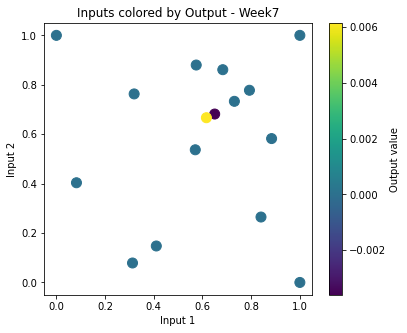

/var/folders/6g/73j8cd_50jx2t57s_f2s9jyw0000gn/T/ipykernel_95156/2442154178.py:32: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)


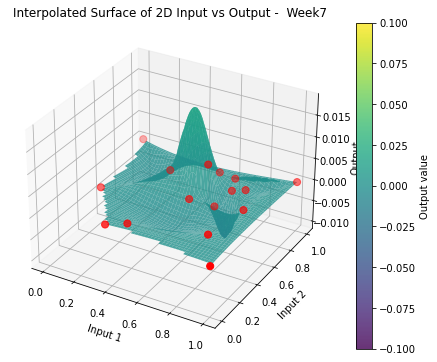

In [3]:
# Now plot the data
# Flatten output to 1D
y = outputdata_week7.flatten()
x1 = inputdata_week7[:,0]
x2 = inputdata_week7[:,1]
X = inputdata_week7
print(inputdata_week7)
print(outputdata_week7)

#2D scatter plot 
plt.figure(figsize=(6,5))
plt.scatter(x1, x2, c=y, cmap='viridis', s=100)
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Inputs colored by Output - Week7')
plt.colorbar(label='Output value')
plt.show()


# Create a grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x1.min(), x1.max(), 100),
    np.linspace(x2.min(), x2.max(), 100)
)

# Interpolate output values on the grid
grid_z = griddata((x1, x2), y, (grid_x, grid_y), method='cubic')

# Plot surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.8)

# Plot original points on top
ax.scatter(x1, x2, y, color='red', s=50, label='Original points')

ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Output')
plt.title('Interpolated Surface of 2D Input vs Output -  Week7')
fig.colorbar(surf, label='Output value')
plt.show()

### Step 3: Updated SVM & GP surrogate model - previous week looked to work, try again and see what this round provides

In [15]:
EPS = 1e-8
active = (np.abs(y) > EPS).astype(int)

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Have updated SVM : was too permissive, now i have improved discrimination by making SVM sharper. Reducing false positives in empty regions

svm = make_pipeline(
    StandardScaler(),
    SVC(
    kernel="rbf",
    C=50.0,          # stronger margin
    gamma=5.0,       # tighter locality
    probability=True,
    class_weight={0:1, 1:3},  # bias toward active regions
    random_state=42
)
)

svm.fit(X, active)

# Train GP on non-zero points
X_active = X[active == 1]
y_active = y[active == 1]

EPS = 1e-12

if len(y_active) >= 3:
    X_gp = X_active
    y_gp = np.log10(np.abs(y_active) + EPS)
else:
    X_gp = X
    y_gp = np.log10(np.abs(y) + EPS)

kernel = Matern(length_scale=0.15, nu=1.5) ## Kernal was too smooth for proximity only, so have updated from nu=2.5 to 1.5
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_gp, y_gp)

GaussianProcessRegressor(kernel=Matern(length_scale=0.15, nu=1.5),
                         n_restarts_optimizer=10, random_state=42)

## Step 4: Update candidate space and acquisition function - this time relaxing the candidate space back to [0,1] to see what happens

In [16]:
# Candidate points

# Create candidate points to search within
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.column_stack([X1.ravel(), X2.ravel()])


p_active = svm.predict_proba(X_candidates)[:, 1]

mu, sigma = gp.predict(X_candidates, return_std=True)

kappa = 2.0
ucb = mu + kappa * sigma
acq = p_active * ucb

print(acq)

[-0.2056888  -0.22969335 -0.25469764 ... -1.76523303 -1.789696
 -1.80643606]


## Step 5: Exclude previously sampled points and identify next candidate points

In [17]:
from scipy.spatial.distance import cdist

min_dist = np.min(cdist(X_candidates, X), axis=1)
acq[min_dist < 5e-3] = -np.inf

x_next = X_candidates[np.argmax(acq)]
print(np.round(x_next,6))

[0.636364 0.666667]
